## Single-cell run dataset exploration

### 0. Importing data and packages 

In [4]:
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
sns.set_style("white")
random.seed(42)

/Users/valdemaras/Programs/miniconda/miniconda3/envs/singleCell/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Reading data 
sc = pd.read_csv('data/SN17/SN17-R11-29min-1cell-QBL_PG.tsv', delimiter= "\t", decimal = ",") # does not work with the comma decimanl...
#Replacing filtered with NA 
acc_genes = sc.iloc[:,0:2]
sc = sc.replace("Filtered", np.nan).drop('PG.Genes', axis = 1).set_index('PG.ProteinGroups')
sc.columns = ["Cell_" + str(n) for n in range(1,sc.shape[1]+1)]
sc = sc.apply(lambda x: x.str.replace(',', '.').astype(float)) # this seems to do the trick

### 1. Detected number of proteins and sample intensity 

In [6]:
protein_numbers = sc.shape[0] - sc.isna().sum() 
quantified_proteins = pd.DataFrame({'Cell': protein_numbers.index, 'QuantifiedProteins': protein_numbers.values})

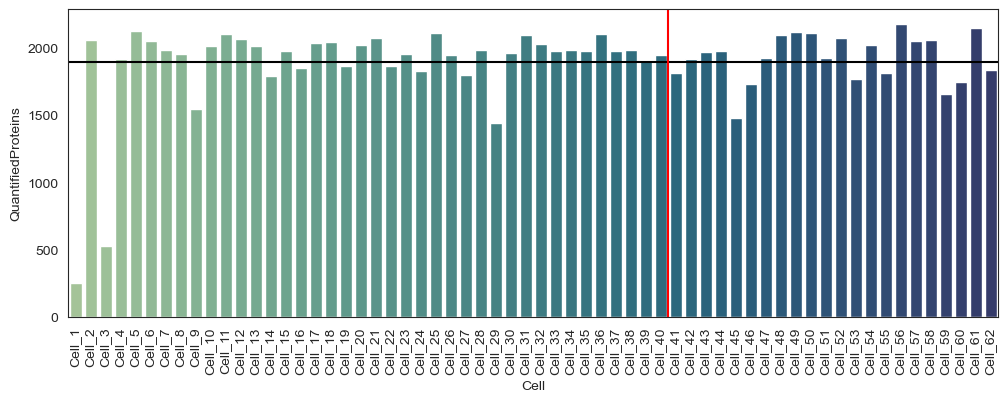

In [7]:
fig, axes  = plt.subplots(figsize = (12,4))
fig = sns.barplot(data=quantified_proteins, x = 'Cell', y = 'QuantifiedProteins', palette= 'crest')
plt.xticks(rotation=90)
fig.axhline(quantified_proteins.QuantifiedProteins.mean(), color = "k")
fig.axvline(39.5, color ="r")

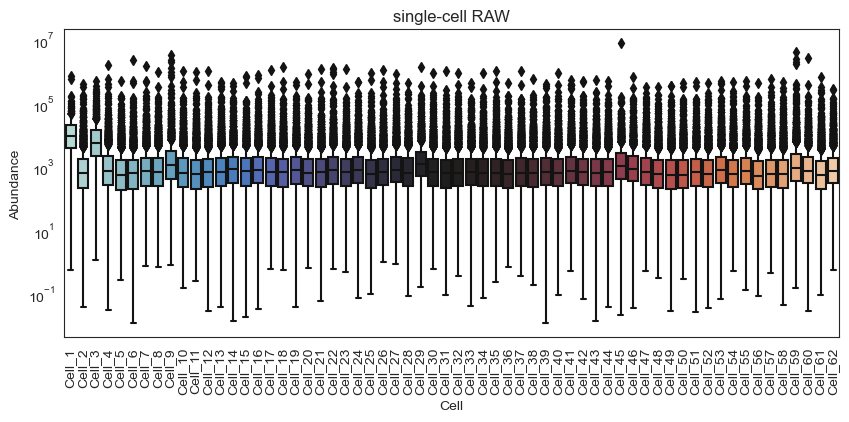

In [8]:
def scBoxplotLog(df, myTitle):
    protLong = pd.melt(df, value_vars = sc.columns);protLong.columns = ['Cell', "Abundance"]
    #Filter out NAs 
    protLong = protLong[protLong.Abundance.isna() != True]
    fig, axes = plt.subplots(figsize=(10, 4))
    plt.xticks(rotation=90)
    axes.set_yscale("log")
    sns.boxplot(x= 'Cell', y = 'Abundance', data = protLong, palette= 'icefire').set_title(myTitle)

scBoxplotLog(sc, "single-cell RAW")

Cells 3 and 1 are filtered out leaving 60 single-cells

In [9]:
#Droping cell 3 and 1 
sc = sc.drop(['Cell_1', 'Cell_3'], axis=1)

### 2. Clustering of RAW abundance values

#### 2.0 Missing value imputation and transformation/scaling

In [21]:
#Imputing missing values with knn 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10, weights="uniform")
sc_imp = pd.DataFrame(imputer.fit_transform(sc))
sc_imp.columns = sc.columns;sc_imp.index = sc.index

sc_imp_log = np.log2(sc_imp) # log transform
sc_imp_scale = sc_imp.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 0)
sc_imp_scale2 = sc_imp_scale.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1) # winning normalization method 

#### 2.1 PCA

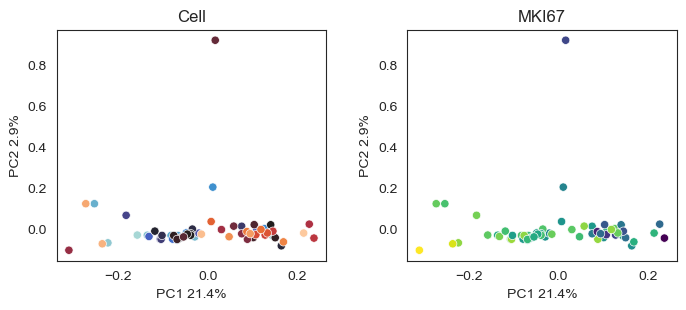

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
#pca.fit(np.log2(abundances_knn)) # just log transformed
pca.fit(sc_imp_scale2) # scaled values 
pca_2 = pd.DataFrame(pca.components_)

#Formating PCA results for ploting 
pca_2 = pca_2.transpose()
pca_2.reset_index(level=0, inplace=True)
pcas =  ["PC1", "PC2", "PC3", "PC4", "PC5"]
test = [p + " " + str(np.round(v,1)) + "%" for p,v in zip(pcas, pca.explained_variance_)]
test.insert(0, 'Sample')
pca_2.columns = test

pca_2['Sample'] = sc_imp_scale.columns.str.extract(r'(Cell.*)')[0]
pca_2['MKI67'] = sc_imp_scale2.loc[sc.index == "P46013",:].values[0]
pca_2
fig, axes = plt.subplots(1,2,figsize=(8,3), facecolor = "w")

sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Sample", legend = False, palette= "icefire", ax = axes[0]).set_title('Cell')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "MKI67", legend = False, palette= "viridis", ax = axes[1]).set_title('MKI67')
plt.subplots_adjust(wspace = 0.3)

#### 2.2 UMAP

Text(0.5, 1.0, 'MKI67')

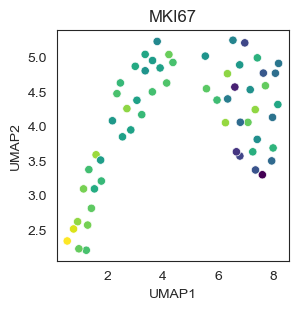

In [23]:
reducer = umap.UMAP() 
#Scaling the imputed abundance values 
embedding = reducer.fit_transform(sc_imp_scale2.T)
embedding.shape

#Reformat into a dataframe
sc_emb = pd.DataFrame({'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'MKI67': sc_imp_scale2.loc[sc.index == "P46013",:].values[0],
                       'Cell': sc_imp.columns})

fig, axes  = plt.subplots(figsize = (3,3))
sns.scatterplot(data = sc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'MKI67', palette = "viridis", legend = False).set_title('MKI67')

## Adding the 52min gradient cells to boost the dataset

In [24]:
#Reading data 
sc52 = pd.read_csv('data/SN17/SN17-R11-52min-1cell-QBL_PG.tsv', delimiter= "\t", decimal = ",") # does not work with the comma decimanl...
#Replacing filtered with NA 
acc_genes52 = sc52.iloc[:,0:2]
sc52 = sc52.replace("Filtered", np.nan).drop('PG.Genes', axis = 1).set_index('PG.ProteinGroups')
sc52.columns = ["Cell_" + str(n) for n in range(1,sc52.shape[1]+1)]
sc52 = sc52.apply(lambda x: x.str.replace(',', '.').astype(float)) # this seems to do the trick

In [25]:
protein_numbers52 = sc52.shape[0] - sc52.isna().sum() 
quantified_proteins52 = pd.DataFrame({'Cell': protein_numbers52.index, 'QuantifiedProteins': protein_numbers52.values})

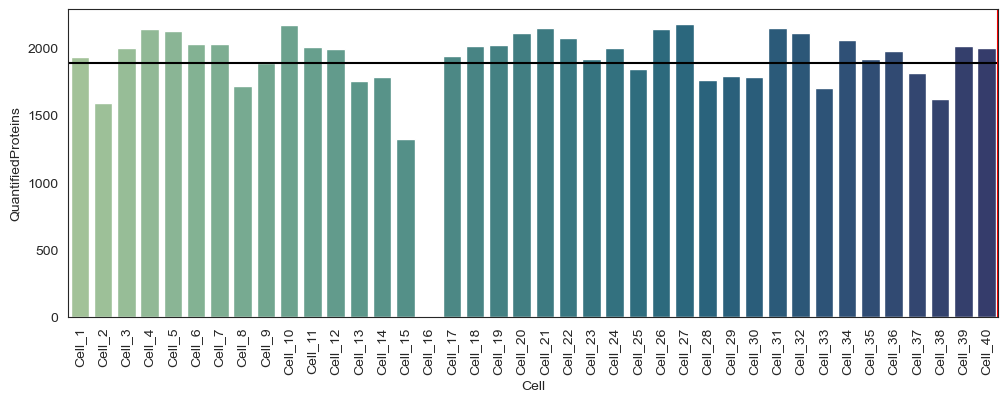

In [26]:
fig, axes  = plt.subplots(figsize = (12,4))
fig = sns.barplot(data=quantified_proteins52, x = 'Cell', y = 'QuantifiedProteins', palette= 'crest')
plt.xticks(rotation=90)
fig.axhline(quantified_proteins52.QuantifiedProteins.mean(), color = "k")
fig.axvline(39.5, color ="r")

In [27]:
#Droping cell 3 and 1 
sc52 = sc52.drop(['Cell_16', 'Cell_38'], axis=1)

In [28]:
#Imputing missing values with knn 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10, weights="uniform")
sc52_imp = pd.DataFrame(imputer.fit_transform(sc52))
sc52_imp.columns = sc52.columns;sc52_imp.index = sc52.index

sc52_imp_log = np.log2(sc52_imp) # log transform
sc52_imp_scale = sc52_imp.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 0)
sc52_imp_scale2 = sc52_imp_scale.apply(lambda x: (x - np.nanmean(x))/np.nanstd(x), axis = 1) # winning normalization method 

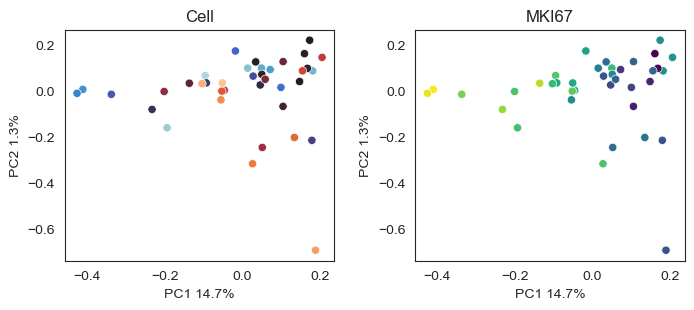

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
#pca.fit(np.log2(abundances_knn)) # just log transformed
pca.fit(sc52_imp_scale2) # scaled values 
pca_2 = pd.DataFrame(pca.components_)

#Formating PCA results for ploting 
pca_2 = pca_2.transpose()
pca_2.reset_index(level=0, inplace=True)
pcas =  ["PC1", "PC2", "PC3", "PC4", "PC5"]
test = [p + " " + str(np.round(v,1)) + "%" for p,v in zip(pcas, pca.explained_variance_)]
test.insert(0, 'Sample')
pca_2.columns = test

pca_2['Sample'] = sc52_imp_scale.columns.str.extract(r'(Cell.*)')[0]
pca_2['MKI67'] = sc52_imp_scale2.loc[sc52.index == "P46013;P46013-2",:].values[0]
pca_2
fig, axes = plt.subplots(1,2,figsize=(8,3), facecolor = "w")

sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "Sample", legend = False, palette= "icefire", ax = axes[0]).set_title('Cell')
sns.scatterplot(data = pca_2, x = pca_2.columns[1], y = pca_2.columns[2], hue = "MKI67", legend = False, palette= "viridis", ax = axes[1]).set_title('MKI67')
plt.subplots_adjust(wspace = 0.3)

Text(0.5, 1.0, 'MKI67')

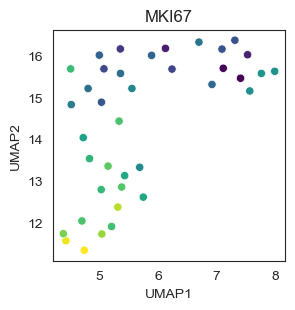

In [30]:
reducer = umap.UMAP() 
#Scaling the imputed abundance values 
embedding = reducer.fit_transform(sc52_imp_scale2.T)
embedding.shape

#Reformat into a dataframe
sc52_emb = pd.DataFrame({'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'MKI67': sc52_imp_scale2.loc[sc52.index == "P46013;P46013-2",:].values[0],
                       'Cell': sc52_imp.columns})

fig, axes  = plt.subplots(figsize = (3,3))
sns.scatterplot(data = sc52_emb, x = 'UMAP1', y = 'UMAP2', hue = 'MKI67', palette = "viridis", legend = False).set_title('MKI67')

## Trying to combine the two datasets 

In [33]:
sc52_imp_scale2.columns = ["Cell_" + str(n) for n in range(63,63 + sc52.shape[1])]
sc_imp_scale2['Genes'] = acc_genes['PG.Genes'].values[:]
sc52_imp_scale2['Genes'] = acc_genes52['PG.Genes'].values[:]

scc = sc_imp_scale2.reset_index().merge(sc52_imp_scale2,left_on = 'Genes', right_on = 'Genes').set_index('PG.ProteinGroups')
scc = scc.drop(columns=['Genes'])

ValueError: Length mismatch: Expected axis has 39 elements, new values have 38 elements

### Checking if samples do not cluster by gradient

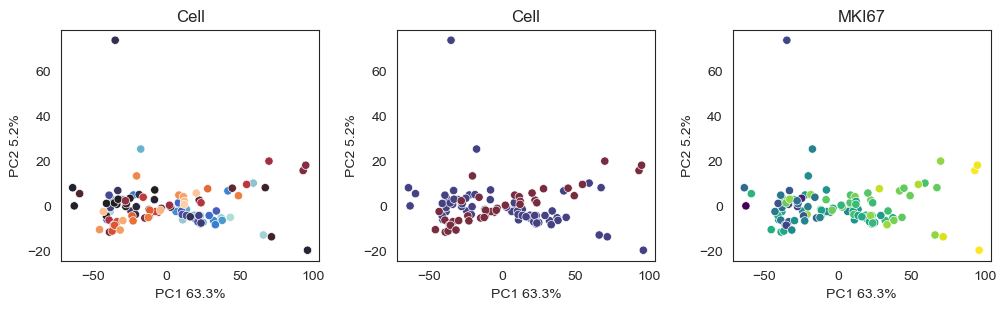

In [34]:
pca = PCA(n_components=5)
#pca.fit(np.log2(abundances_knn)) # just log transformed
pca.fit(scc.T) # scaled values 
pca_2 = pca.transform(scc.T)

#Making PCA column labels
pc_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
pcas =  ["PC1", "PC2", "PC3", "PC4", "PC5"]
pca_labels = [p + " " + str(np.round(v,1)) + "%" for p,v in zip(pcas, pc_var)]

#Making data frame for plotting 
pca_df = pd.DataFrame(pca_2, index = range(pca_2.shape[0]), columns = pca_labels)
pca_df['Sample'] = scc.columns.str.extract(r'(Cell.*)')[0]
pca_df['MKI67'] = scc.loc[scc.index == "P46013",:].values[0]
pca_df['Gradient'] = np.concatenate((np.repeat('29min', 60), np.repeat('52min', 38)))
pca_df
fig, axes = plt.subplots(1,3,figsize=(12,3), facecolor = "w")

sns.scatterplot(data = pca_df, x = pca_df.columns[0], y = pca_df.columns[1], hue = "Sample", legend = False, palette= "icefire", ax = axes[0]).set_title('Cell')
sns.scatterplot(data = pca_df, x = pca_df.columns[0], y = pca_df.columns[1], hue = "Gradient", legend = False, palette= "icefire", ax = axes[1]).set_title('Cell')
sns.scatterplot(data = pca_df, x = pca_df.columns[0], y = pca_df.columns[1], hue = "MKI67", legend = False, palette= "viridis", ax = axes[2]).set_title('MKI67')
plt.subplots_adjust(wspace = 0.3)

pca_df.to_csv("results/pca.csv", sep = "\t")

### UMAP of merged dataset

Text(0.5, 1.0, 'MKI67')

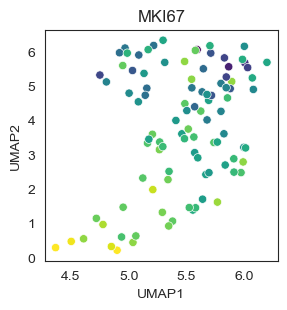

In [37]:
reducer = umap.UMAP(n_components=3, n_neighbors = 15)
#Scaling the imputed abundance values 
embedding = reducer.fit_transform(scc.T)
embedding.shape

#Reformat into a dataframe
scc_emb = pd.DataFrame({'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'MKI67': scc.loc[scc.index == "P46013",:].values[0],
                       'Cell': scc.columns})

fig, axes  = plt.subplots(figsize = (3,3))
sns.scatterplot(data = scc_emb, x = 'UMAP1', y = 'UMAP2', hue = 'MKI67', palette = "viridis", legend = False).set_title('MKI67')

#save the umap 
#scc_emb.to_csv("results/umap.csv", sep = "\t")